In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 150
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\sansk\Downloads\chest x ray-20231106T114602Z-001\chest x ray",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5856 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

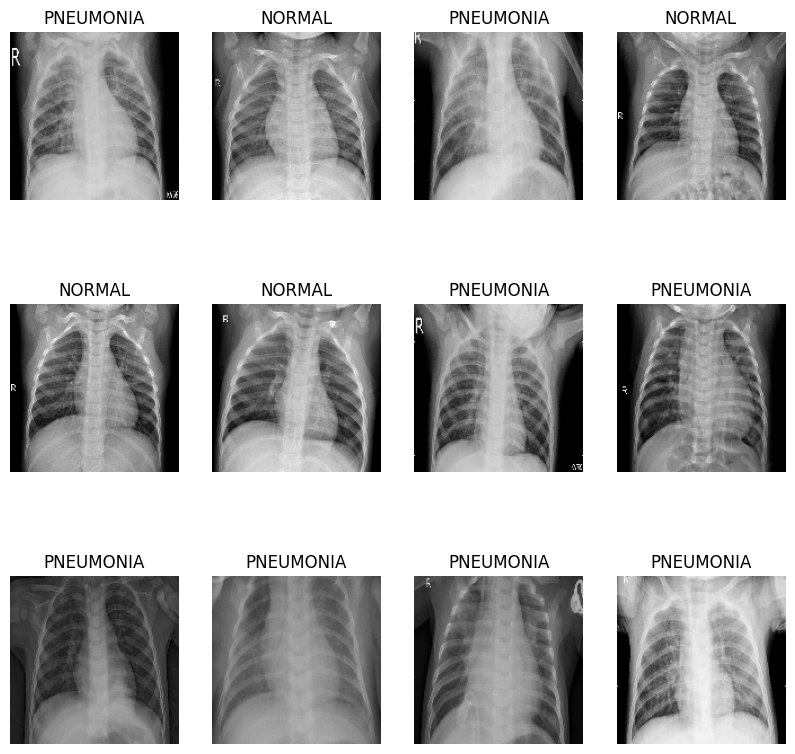

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
resize_and_rescale = Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = 2

model = Sequential([
    resize_and_rescale,
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(256, (5, 5), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(384, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(384, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
73/73 [==============================] - 24s 148ms/step - loss: 0.4535 - accuracy: 0.8517 - val_loss: 1.3651 - val_accuracy: 0.7326
Epoch 2/50
73/73 [==============================] - 17s 135ms/step - loss: 0.2220 - accuracy: 0.9194 - val_loss: 1.2313 - val_accuracy: 0.7535
Epoch 3/50
73/73 [==============================] - 17s 137ms/step - loss: 0.1668 - accuracy: 0.9399 - val_loss: 1.9576 - val_accuracy: 0.7537
Epoch 4/50
73/73 [==============================] - 17s 137ms/step - loss: 0.1604 - accuracy: 0.9386 - val_loss: 0.8846 - val_accuracy: 0.7083
Epoch 5/50
73/73 [==============================] - 17s 135ms/step - loss: 0.1385 - accuracy: 0.9506 - val_loss: 0.2160 - val_accuracy: 0.9184
Epoch 6/50
73/73 [==============================] - 17s 137ms/step - loss: 0.1257 - accuracy: 0.9537 - val_loss: 0.1546 - val_accuracy: 0.9462
Epoch 7/50
73/73 [==============================] - 17s 137ms/step - loss: 0.1257 - accuracy: 0.9515 - val_loss: 0.4426 - val_accuracy: 0.7986

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

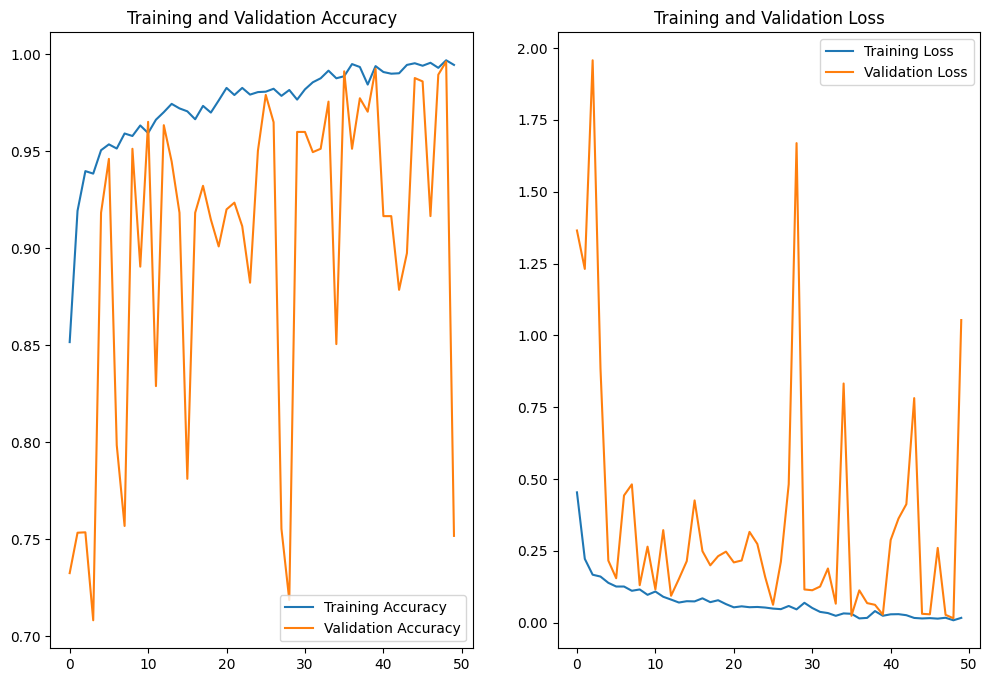

In [14]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
import numpy as np
true_labels = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())

In [16]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

10/10 [==============================] - 8s 13ms/step


In [17]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.43      0.05      0.09       178
           1       0.73      0.97      0.83       462

    accuracy                           0.72       640
   macro avg       0.58      0.51      0.46       640
weighted avg       0.64      0.72      0.63       640



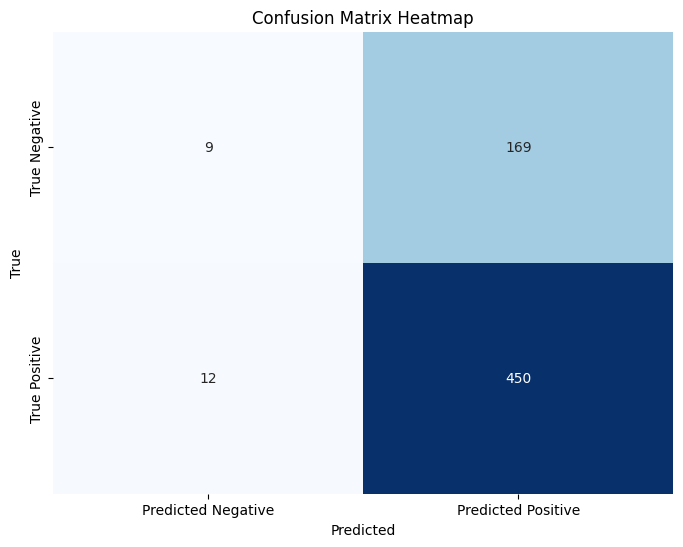

In [18]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(true_labels, predicted_labels)
confusion
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(test_ds)

10/10 [==============================] - 8s 31ms/step - loss: 1.1924 - accuracy: 0.7578


first image to predict
actual label: PNEUMONIA
2/2 [==============================] - 0s 55ms/step
predicted label: PNEUMONIA


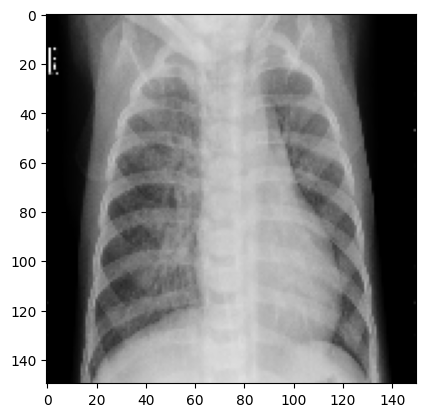

In [20]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [21]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


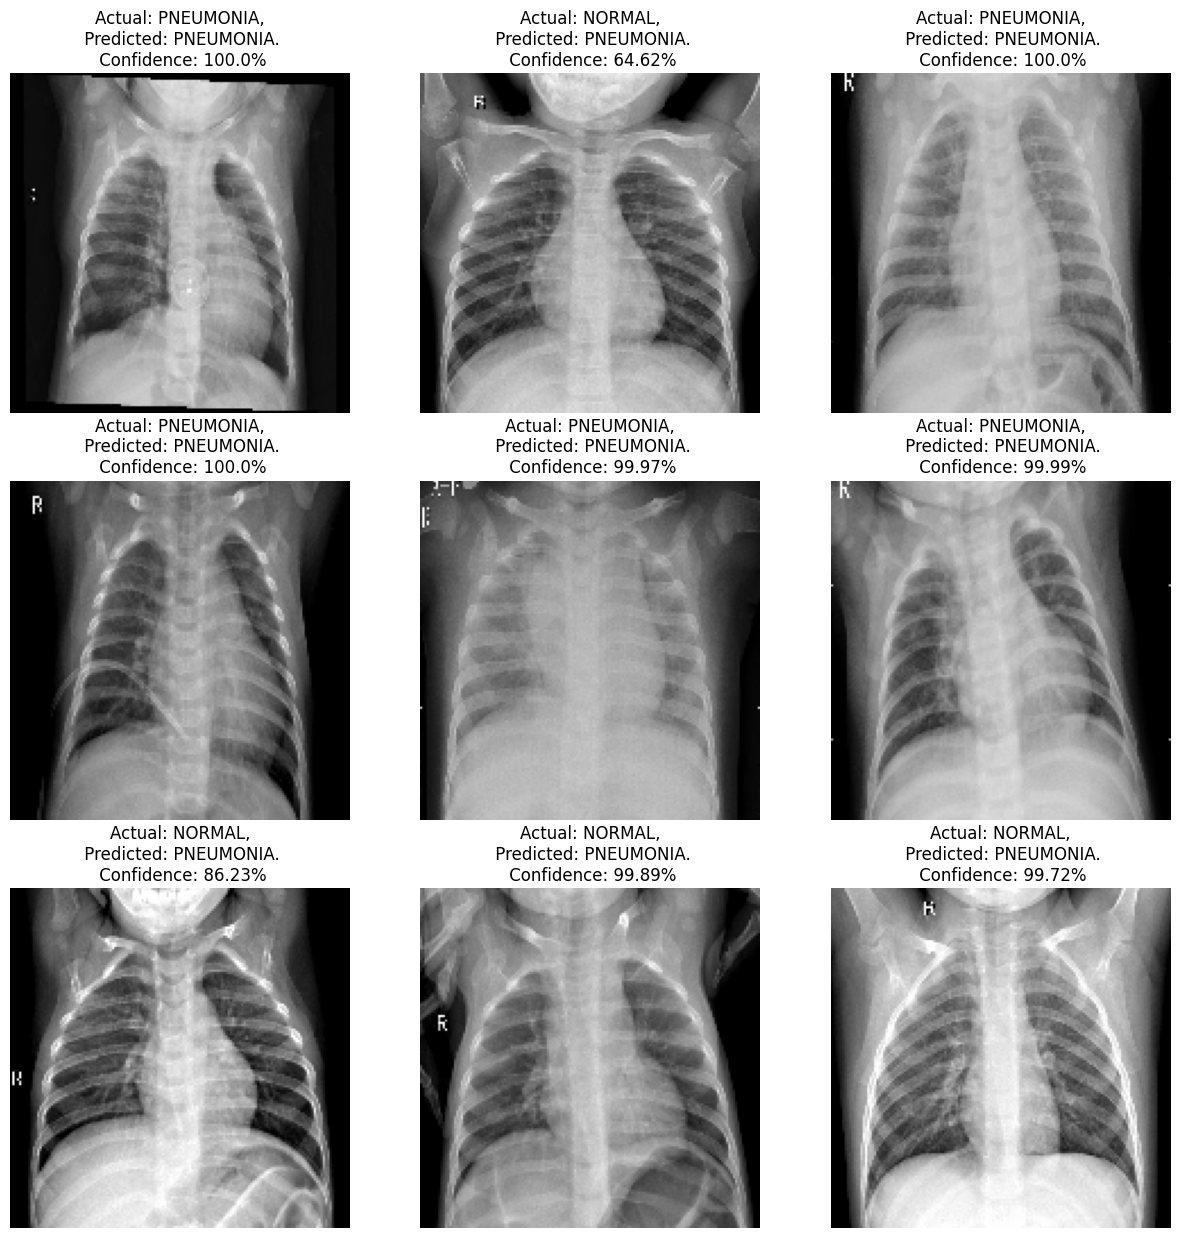

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")